# Unos biblioteka

In [1]:
import numpy as np
import pandas as pd
import os
import random
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

Tema da li se ljudi opredeljuju za vakcinu, koju vakcinu najčešće i zbog čega nije pitanje koje se postavilo prvi put tokom pandemije COVID-19 virusom. Istorija se ponavlja, a uz pomoć prikupljenih podataka kroz anketiranje stanovnika Sjedinjenih Američkih Država, može se dobiti nešto drugačiji uvid u raspoloženje ljudi kada je u pitanju vakcina. Interpretabilnost ovakvih modela je ključna za razumevanje odnosa ljudi prema ovom vidu sprečavanja epidemija i pandemija. Stoga je u istraživanju izuzeta upotreba neuralnih mreža kao klasifikatora čija je interpretabilnost nemoguća.  
U priloženoj svesci se nalazi analiza dostupnih podataka, proces njihove obrade i obučavanje klasifikatora koji može biti koristan u predikciji novoanketiranih osoba u vezi njihove odluke da prime ili odbiju vakcinu.

# Podaci

## Učitavanje podataka i prikaz osnovnih informacija

In [2]:
features_raw_df = pd.read_csv("data/training_set_features.csv")
output_df = pd.read_csv("data/training_set_labels.csv")
output_columns = output_df.columns.tolist()[1:]
data_raw_df = pd.concat((features_raw_df, output_df[output_columns]), axis=1)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prediktori za donošenje odluka ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
display(data_raw_df.sample(5))

print("\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Osnovne informacije o podacima ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
data_raw_df.info()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prediktori za donošenje odluka ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
12754,12754,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Own,Not in Labor Force,oxchjgsf,"MSA, Not Principle City",2.0,1.0,NaN,NaN,0,0
9010,9010,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Own,Employed,oxchjgsf,Non-MSA,1.0,0.0,fcxhlnwr,cmhcxjea,0,1
19378,19378,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Own,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",2.0,0.0,NaN,NaN,0,0
1409,1409,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Own,Employed,fpwskwrf,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,1
6399,6399,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Own,Employed,qufhixun,Non-MSA,1.0,0.0,pxcmvdjn,mxkfnird,0,0




~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Osnovne informacije o podacima ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         2454

U dostupnim podacima se nalaze informacije o 26707 osoba. Od 35 prediktora, ukoliko izuzmemo ID osobe (indeks), 12 je kategoričkih i oni će biti posebno analizirani, a ostatalih 23 je predstavljeno kao realan broj.  

U podacima su dostupne dve izlazne labele:  
- **h1n1_vaccine**: 1 ukoliko je ispitanik vakcinisan/za vakcinu protiv H1N1 virusa
- **seasonal_vaccine**: 1 ukoliko je ispitanik vakcinisan/za vakcinu  protiv sezonskog gripa  

## Pregled osnovnih statistika svakog prediktora

In [3]:
data_raw_df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


Bitan zaključak pregleda osnovnih statistika je da, iako su prediktori predstavljeni kao realni brojevi zapravo u većini slučajeva jesu diskretne vrenosti.

## Čišćenje podataka

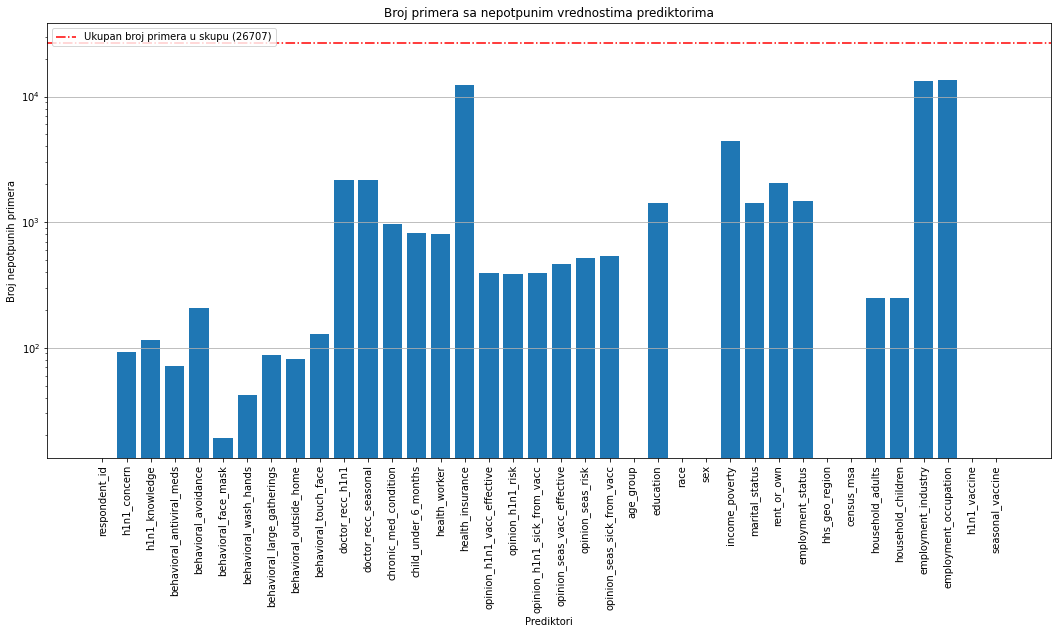

In [4]:
counts = data_raw_df.isna().sum()
count_dict = {counts.index[i]: cnt for i, cnt in enumerate(counts)}
bar_pos = [i for i in range(len(count_dict))]

# Prikaz
plt.figure(figsize=(18,8))
plt.bar(bar_pos, count_dict.values())
plt.axhline(y=26707, color='r', linestyle='-.')
plt.xticks(bar_pos, count_dict.keys(), rotation=90)
plt.yscale('log')
plt.grid(axis='y')
plt.legend(['Ukupan broj primera u skupu (26707)'], loc='upper left')
plt.ylabel('Broj nepotpunih primera')
plt.xlabel('Prediktori')
plt.title("Broj primera sa nepotpunim vrednostima prediktorima")
plt.savefig('images/counted_nans.png')
plt.show()

Samo 5 od 35 prediktora imaju svoju vrednost kod svih osoba. Međutim, za 3 prediktora nedostaje informacija za skoro polovinu ispitanika čije bi odbacivanje ugrozilo generalizaciju i obučavanje modela. 

Broj zadržanih prediktora je 13/35
Prag 200 | Broj preostalih podataka 26157
Broj zadržanih prediktora je 19/35
Prag 400 | Broj preostalih podataka 25358
Broj zadržanih prediktora je 20/35
Prag 500 | Broj preostalih podataka 25318
Broj zadržanih prediktora je 22/35
Prag 800 | Broj preostalih podataka 25238
Broj zadržanih prediktora je 24/35
Prag 900 | Broj preostalih podataka 25024
Broj zadržanih prediktora je 25/35
Prag 1000 | Broj preostalih podataka 24803
Broj zadržanih prediktora je 28/35
Prag 2000 | Broj preostalih podataka 24002
Broj zadržanih prediktora je 32/35
Prag 5000 | Broj preostalih podataka 19642


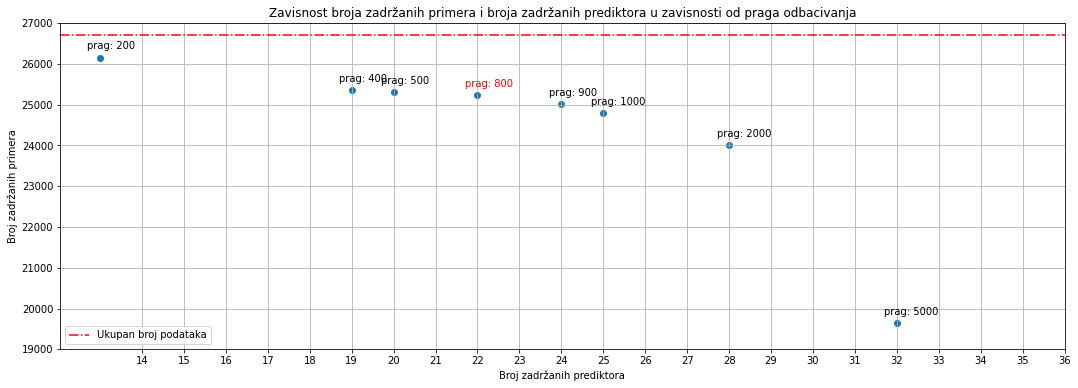

Broj zadržanih prediktora je 22/35


In [5]:
def filter_by_nan(df: pd.DataFrame, threshold: int = 1e3) -> pd.DataFrame: 
    """ Svi prediktori koji imaju broj nepotpunih primera veći od praga će biti odbačeni """
    if "respondent_id" in df.columns:
        df.drop(columns=["respondent_id"], inplace=True)
    # Brojanje nedostajućih vrednosti po kolonama
    nan_counts = df.isna().sum()
    # Lista prediktora koje treba ukloniti
    predictors_to_keep = [nan_counts.index[ind] for ind, cnt in enumerate(nan_counts) if cnt < threshold]
    print(f"Broj zadržanih prediktora je {len(predictors_to_keep)-2}/{len(nan_counts)-2}")
    return df[predictors_to_keep]

# Eksperiment pri za izbor praga odbacivanja
num_predictors, num_examples = [], []
thresholds = [200, 400, 500, 800, 900, 1000, 2000, 5000]
for threshold in thresholds:
    # Uklanjanje podataka preko praga
    new_df = filter_by_nan(data_raw_df, threshold)
    new_df = new_df.dropna()
    num_predictors.append(new_df.shape[1]-2)
    num_examples.append(len(new_df))
    print(f"Prag {threshold} | Broj preostalih podataka", len(new_df))
    
# Grafički prikaz
fig = plt.figure(figsize=(18,6))
plt.scatter(num_predictors, num_examples)
plt.axhline(y=26707, color='r', linestyle='-.')
for x, y, s in zip(num_predictors, num_examples, thresholds):
    if s != 800:
        plt.text(x-0.3, y+200, f"prag: {s}", c='k')
    else:
        plt.text(x-0.3, y+200, f"prag: {s}", c='r')
        
plt.title("Zavisnost broja zadržanih primera i broja zadržanih prediktora u zavisnosti od praga odbacivanja")
plt.legend(["Ukupan broj podataka"])
plt.ylabel("Broj zadržanih primera")
plt.xlabel("Broj zadržanih prediktora")
plt.xticks(range(14,37))
plt.ylim([19000, 27000])
plt.grid()
fig.savefig('images/roc_cleaning.png')
plt.show()

    
# Odbacivanje prediktora iznad emprijski određenog praga
data_df = filter_by_nan(data_raw_df, threshold=800).dropna()

# Ispunjavanje preostlih nedostajučih vrednosti pomoću medijane prediktora
# data_df = data_df.fillna(data_df.median())

Odbacivanje samo tri očigledno nepotpuna prediktora bi rezultovalo gubitkom od ~1/3 podataka. Nešto bolje je postaviti prag na 800 i predikciju raditi sa 22 prediktora i gubitkom od ~1500 primera (5.61% skupa). Kako je skup dovoljno veliki, ostatak nepotpunih primera je odbačen iz skupa.

## Analiza kategoričkih prediktora

Kategoričke prediktore je neophodno posebno analizirati. Njihove vrednosti su tipa *string* u dostupnim podacima i neophodno je primeniti transformacije kako bi svi podaci imali numeričke vrednosti.  

Postoje dve različite stuacije koje na poseban način treba tretirati:  
- **Vrednosti prediktora je moguće gradaciono posmatrati**: U ovom slučaju je neophodno adekvatno sortirati vrednosti po opadajućem ili rastućem poretku. Ovaj prinip je u literaturi poznat kao *label encoding*
- **Vrednosti prediktora je nemoguće gradaciono posmatrati**: U ovom slučaju je neophodno razbiti postojeći prediktora na onoliko prediktora koliko je dostupno jedinstvenih vrednosti u prvobitnom skupu. Svaki novi prediktor je binarna promenljiva koja predstavlja indikator jedinstvene vrednosti originalnog prediktora. Ovaj prinip je u literaturi poznat kao *one-hot encoding*


In [6]:
print("Kategorički prediktori", data_df.select_dtypes(include='object').columns.tolist())

Kategorički prediktori ['age_group', 'race', 'sex', 'hhs_geo_region', 'census_msa']


### Starosna grupa

In [7]:
print("Moguće vrednosti prediktora `age_group` su:\n", data_df['age_group'].unique())

def transform_age(df: pd.DataFrame) -> pd.DataFrame:
    """ Encode categorical features """
    enc = {
        '18 - 34 Years': 0,
        '35 - 44 Years': 1,
        '55 - 64 Years': 2,
        '45 - 54 Years': 3,
        '65+ Years': 4
    }
    df_new = df.copy()
    df_new.age_group = df_new.age_group.apply(lambda x: enc[x])
    return df_new, ['age']

Moguće vrednosti prediktora `age_group` su:
 ['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']


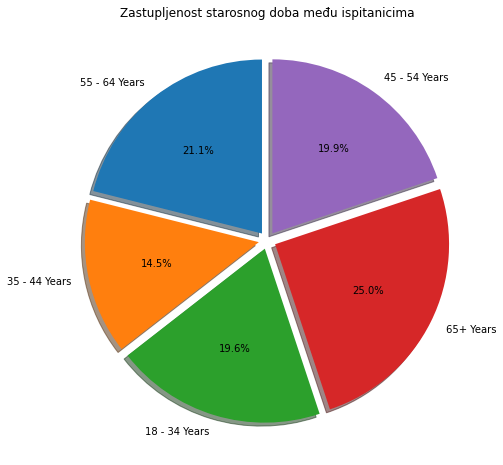

In [8]:
cnt = {cat: len(data_df[data_df['age_group'] == cat]) for cat in data_df['age_group'].unique()}

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(list(cnt.values()), explode=[0.05 for _ in range(len(cnt))], labels=list(cnt.keys()), autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Zastupljenost starosnog doba među ispitanicima")
plt.savefig('images/age_pie.png')
plt.show()

Ovaj kategorički prediktor je moguće gradaciono sortirati od najmlađeg do najstarijeg doba ispitanika i trenutne vrednosti zameniti numeričkim vrednostima. Svako starosno doba je jednako raspodeljeno u podacima.

### Pol

In [9]:
print("Moguće vrednosti prediktora `sex` su:\n", data_df['sex'].unique())

def transform_sex(df: pd.DataFrame) -> pd.DataFrame:
    """ Encode categorical features """
    enc = {
        'Female': 0,
        'Male': 1,
    }
    df_new = df.copy()
    df_new.sex = df_new.sex.apply(lambda x: enc[x])
    return df_new, ['age']

Moguće vrednosti prediktora `sex` su:
 ['Female' 'Male']


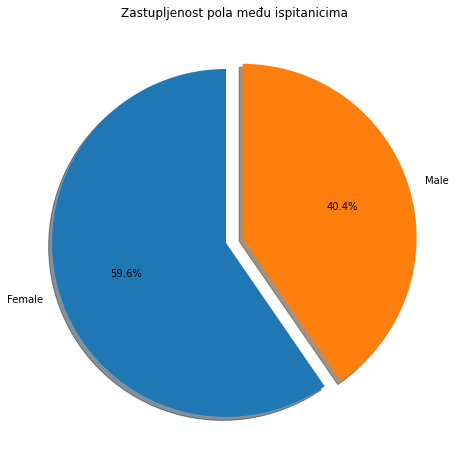

In [10]:
cnt = {cat: len(data_df[data_df['sex'] == cat]) for cat in data_df['sex'].unique()}

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(list(cnt.values()), explode=[0.05 for _ in range(len(cnt))], labels=list(cnt.keys()), autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Zastupljenost pola među ispitanicima")
plt.savefig('images/sex_pie.png')
plt.show()

I ženski u muški ispitanici su prilično slično raspodeljeni u dostupnom skupu podataka. Kako postoje samo dve vrednosti prediktora, moguće je direktno binarizovati ovaj kategorički prediktor.

### Rasa

In [11]:
print("Moguće vrednosti prediktora `race` su:\n", data_df['race'].unique())

def one_hot_encoder(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """ One-hot enkodovanje prediktora """
    # Jedinstvene vrednosti prediktora
    unique_values = df[feature].unique().tolist()
    # Vrednosti prediktora
    values = df[feature].tolist()
    # Rezultujući podaci
    new_df = df.copy()
    # Prolazak kroz jedinstvene vrednosti prediktora
    feature_names = []
    for val in unique_values:
        # Novi prediktor ima vrednost 1 ukoliko prediktor trenutnog primera ima posmatranu vrednost
        values_ = list(map(lambda x: 1 if x == val else 0, values))
        feature_names.append(f"{feature}_{val.split(' ')[0].lower()}")
        new_df[feature_names[-1]] = values_
    # Drop categorical feature
    new_df.drop(columns=[feature], inplace=True)
    return new_df, feature_names

Moguće vrednosti prediktora `race` su:
 ['White' 'Black' 'Other or Multiple' 'Hispanic']


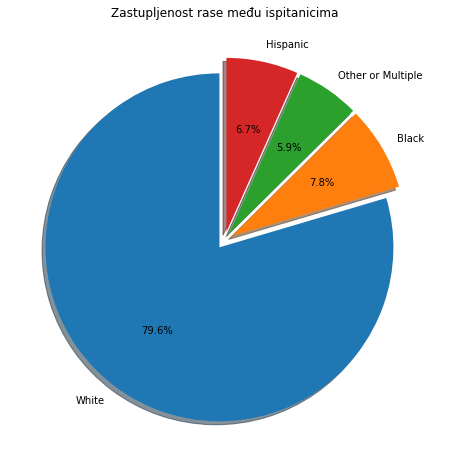

In [12]:
cnt = {cat: len(data_df[data_df['race'] == cat]) for cat in data_df['race'].unique()}

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(list(cnt.values()), explode=[0.05 for _ in range(len(cnt))], labels=list(cnt.keys()), autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Zastupljenost rase među ispitanicima")
plt.savefig('images/race_pie.png')
plt.show()

Bela rasa je ubedljivo najzastupljenija u podacima. Ove prediktore nema smisla porediti i neophodno je "razbiti" postojeći prediktor na 4 nova prediktora primenom *one-hot encoding*-a.

### Geografski region

In [13]:
print("Moguće vrednosti prediktora `hhs_geo_region` su:\n", data_df['hhs_geo_region'].unique())

Moguće vrednosti prediktora `hhs_geo_region` su:
 ['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']


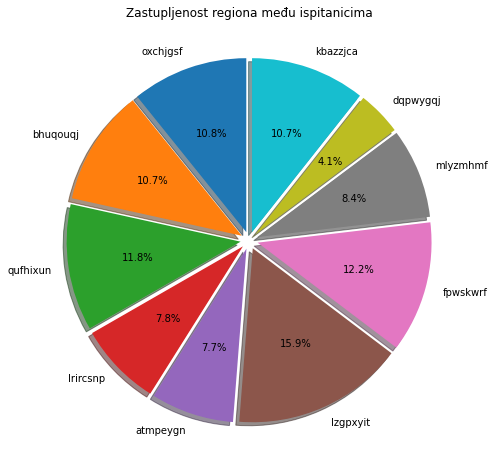

In [14]:
cnt = {cat: len(data_df[data_df['hhs_geo_region'] == cat]) for cat in data_df['hhs_geo_region'].unique()}

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(list(cnt.values()), explode=[0.05 for _ in range(len(cnt))], labels=list(cnt.keys()), autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Zastupljenost regiona među ispitanicima")
plt.savefig('images/hhs_geo_region_pie.png')
plt.show()

Kako je istraživanje, tj. anketa, sprovedeno unutar Sjedinjenih Američkih Država, celokupna teritorija je podeljena na 10 regiona čija su imena sastavljena od skraćenih imena država. Takođe, ni ove prediktore nema smisla porediti i neophodno je "razbiti" postojeći prediktor na 10 novih prediktora primenom *one-hot encoding*-a. Primetimo da je kodiranjem samo poslednja dva prediktora generisano 12 novih prediktora na 22 već postojećih.

### Urbanost grada

In [15]:
print("Moguće vrednosti prediktora `census_msa` su:\n", data_df['census_msa'].unique())

def transform_census_msa(df: pd.DataFrame) -> pd.DataFrame:
    """ Encode categorical features """
    enc = {
        'Non-MSA': 0,
        'MSA, Not Principle  City': 1,
        'MSA, Principle City': 2
    }
    df_new = df.copy()
    df_new.census_msa = df_new.census_msa.apply(lambda x: enc[x])
    return df_new, 'census_msa'

Moguće vrednosti prediktora `census_msa` su:
 ['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']


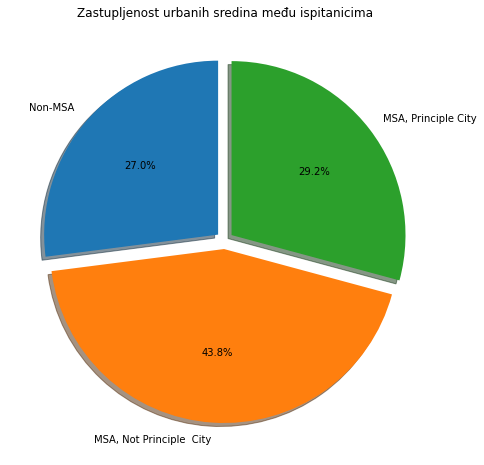

In [16]:
cnt = {cat: len(data_df[data_df['census_msa'] == cat]) for cat in data_df['census_msa'].unique()}

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(list(cnt.values()), explode=[0.05 for _ in range(len(cnt))], labels=list(cnt.keys()), autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Zastupljenost urbanih sredina među ispitanicima")
plt.savefig('images/msa_pie.png')
plt.show()

Urbanost sredine kao prediktor može biti informativan ukoliko je korelisan sa kvalitetom i kvantitetom informacija koje dospevaju do ispitanika u vezi medicine, nauke i virusa. Sve tri vrste urbanih sredina su prilično slično zastupljene i moguće ih je porediti od mesta sa najmanjom populaciom ka mestima sa većom populaciom. Kategorički prediktor je shodno tome zamenjen celobrojnim vrednostima.

### Objedinjavanje kreiranih funkcija

In [17]:
def transform_categorical_features(df: pd.DataFrame):
    """Objedinjena funkcija za transfomacije kategoričkih promenljivih"""
    print(f"Broj kategoričkih prediktora pre transformacije: {len(df.select_dtypes(include='object').columns.tolist())}")
    features = []
    df, f = transform_sex(df)
    features.extend(f)
    df, f = transform_age(df)
    features.extend(f)
    df, f = transform_census_msa(df)
    features.extend(f)
    df, f = one_hot_encoder(df, 'hhs_geo_region')
    features.extend(f)
    df, f = new = one_hot_encoder(df, 'race')
    features.extend(f)
    print(f"Broj kategoričkih prediktora nakon transformacije: {len(features)}")
    return df, list(filter(lambda x: 'race' in x or 'hhs_geo_region' in x, features))

# Transformacija kategoričkih prediktora
transformed_data_df, ohe_features = transform_categorical_features(data_df)

# Prediktori dobijenih one-hot enkodovanjem
print(ohe_features)

transformed_data_df.head()

Broj kategoričkih prediktora pre transformacije: 5
Broj kategoričkih prediktora nakon transformacije: 26
['hhs_geo_region_oxchjgsf', 'hhs_geo_region_bhuqouqj', 'hhs_geo_region_qufhixun', 'hhs_geo_region_lrircsnp', 'hhs_geo_region_atmpeygn', 'hhs_geo_region_lzgpxyit', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_mlyzmhmf', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_kbazzjca', 'race_white', 'race_black', 'race_other', 'race_hispanic']


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,opinion_h1n1_vacc_effective,...,hhs_geo_region_atmpeygn,hhs_geo_region_lzgpxyit,hhs_geo_region_fpwskwrf,hhs_geo_region_mlyzmhmf,hhs_geo_region_dqpwygqj,hhs_geo_region_kbazzjca,race_white,race_black,race_other,race_hispanic
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,...,0,0,0,0,0,0,1,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,...,0,0,0,0,0,0,1,0,0,0


## Međusobna korelisanost pojedinačnih prediktora i korelisanost sa izlazom

### Numerički prediktori

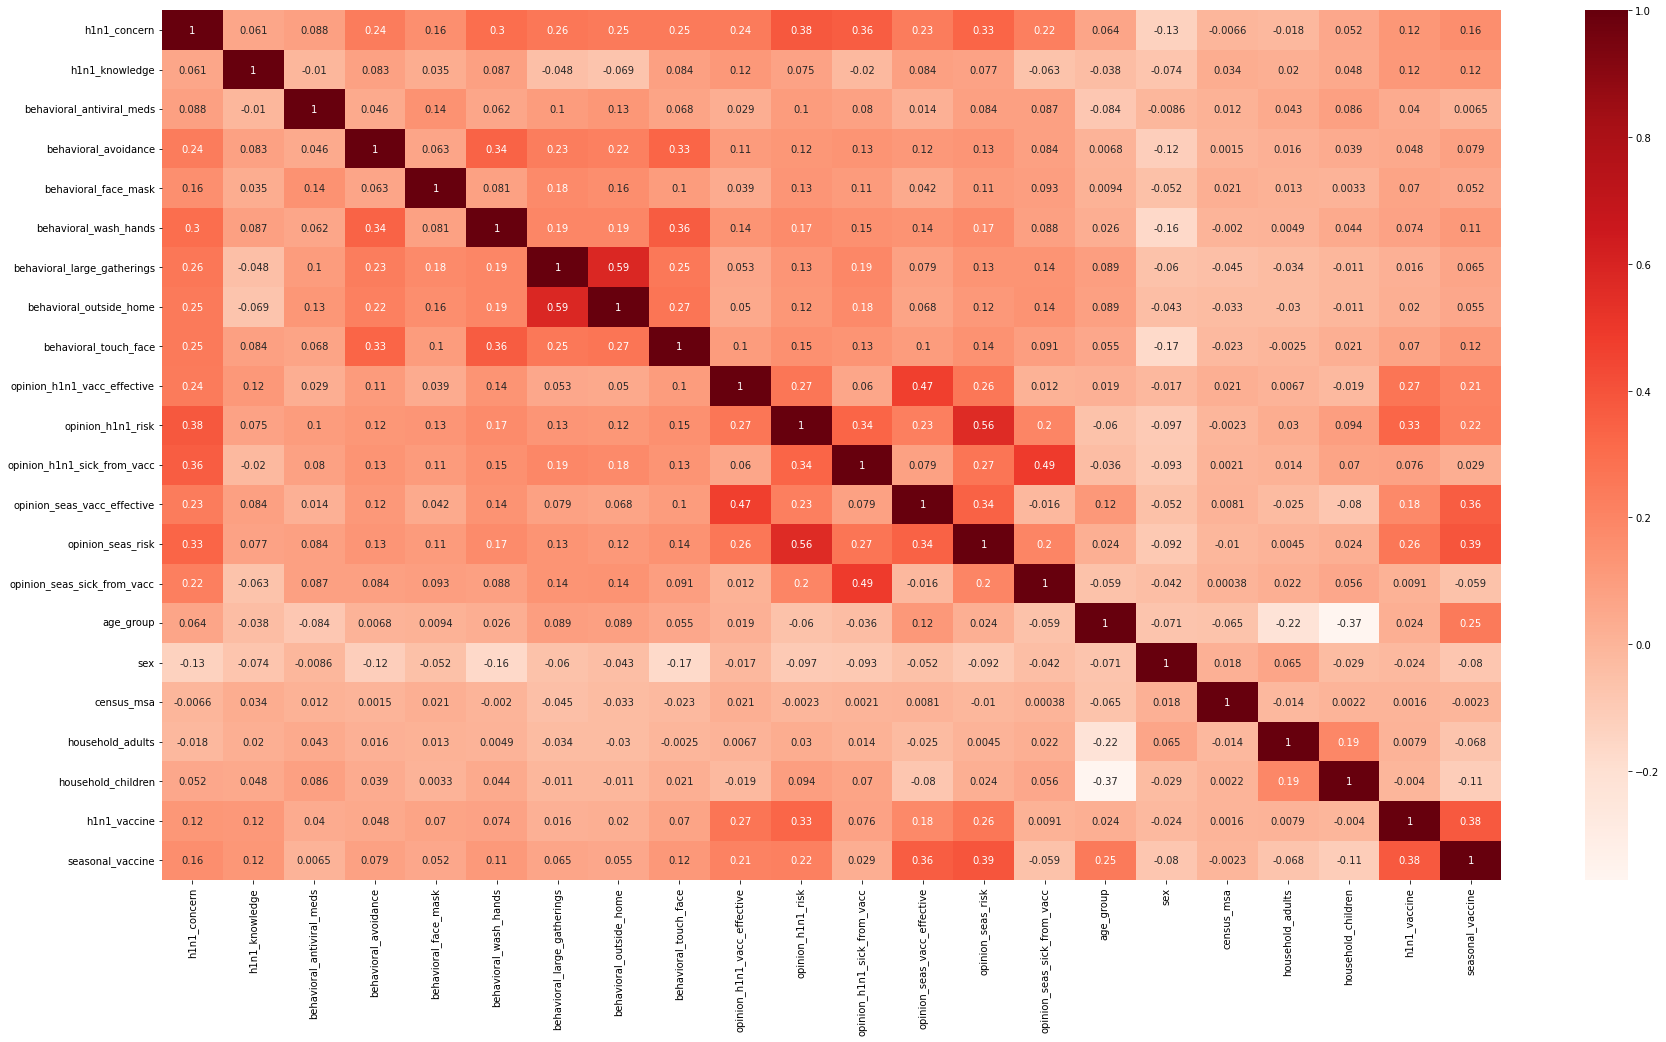

In [18]:
plt.figure(figsize=(30,16))
corr_df = transformed_data_df.drop(columns=ohe_features)
corr = corr_df.corr()
sn.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Nijedan par prediktora nije linearano zavistan do te mere da ga je neophodno ukloniti iz skupa. Interesantno je da postoji značajna korelisanost opredeljenja pacijenata za vakcijanaciju sezonskom i H1N1 vakcinom. Na osnovu korelacije je moguće uočiti i da su ispitanici koji su zabrinuti ili ugroženi od strane sezonskog gripa svoje mišljenje donekle proširili i na virus H1N1.

### Kategorički prediktori

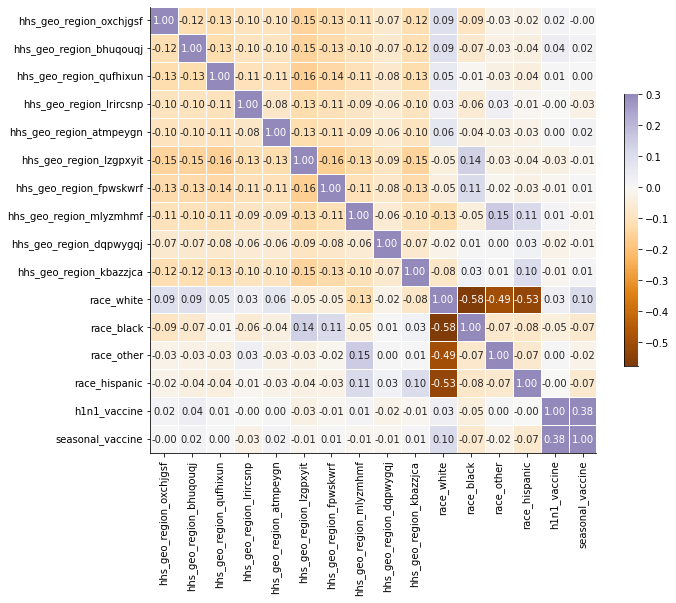

In [19]:
corr_df = transformed_data_df[ohe_features + output_columns]
corr = corr_df.corr()
g = sn.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sn.despine()
g.figure.set_size_inches(10,10)
    
plt.show()

## Analiza mišljenja i znanja ispitanika o virusu/gripu

### H1N1 virus

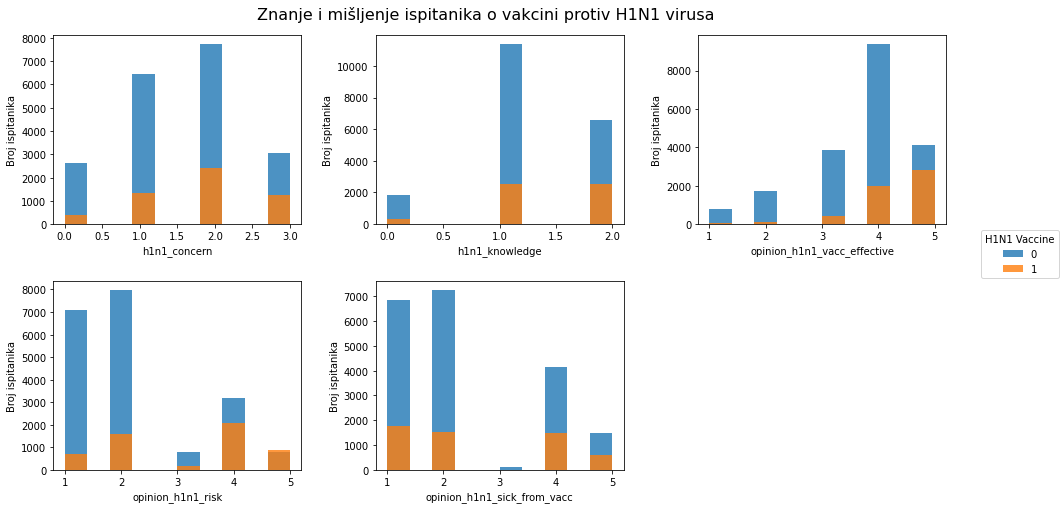

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
numlist=range(1,6)
featurelist=['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']

for i,feature in zip(numlist, featurelist):
    plt.subplot(2,3,i) 
    plt.hist(data=transformed_data_df[transformed_data_df.h1n1_vaccine==0],x=feature, histtype='bar',fill=True, alpha=0.8)
    plt.hist(data=transformed_data_df[transformed_data_df.h1n1_vaccine==1],x=feature, histtype='bar',fill=True, alpha=0.8)
    plt.xlabel(feature)
    plt.ylabel('Broj ispitanika')
    
labels=["0","1"]
fig.legend(labels, loc='center right',title="H1N1 Vaccine")
fig.suptitle("Znanje i mišljenje ispitanika o vakcini protiv H1N1 virusa", fontsize=16, y=0.93)
fig.savefig('images/h1n1_vaccine_knowledge_and_opinion.png')
plt.show()

Opšti zaključak je da se sa porastom znanja i zabrinutosti ispitanika povećava i udeo onih koji će primiti vakcinu.

### Sezonski grip

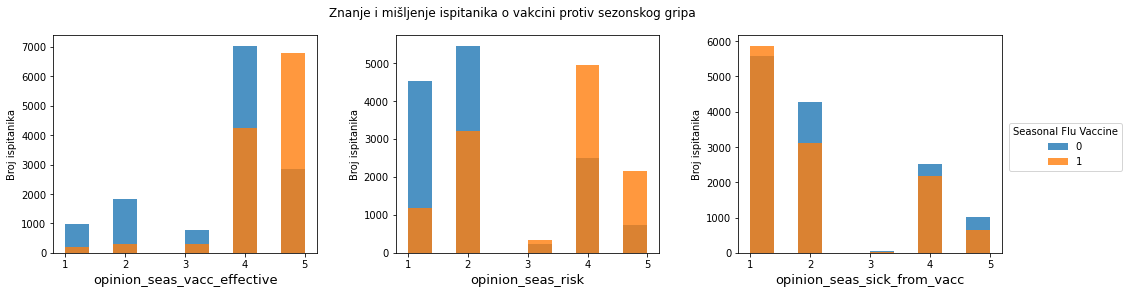

In [21]:
fig, ax = plt.subplots(figsize=(17,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
numlist=range(1,4)
featurelist=['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc']

for i,feature in zip(numlist,featurelist):
    plt.subplot(1,3,i) 
    plt.hist(data=transformed_data_df[transformed_data_df.seasonal_vaccine==0],x=feature, histtype='bar',fill=True, alpha=0.8)
    plt.hist(data=transformed_data_df[transformed_data_df.seasonal_vaccine==1],x=feature, histtype='bar',fill=True, alpha=0.8)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Broj ispitanika')

labels=["0","1"]
fig.legend(labels, loc='center right',title="Seasonal Flu Vaccine")
fig.suptitle("Znanje i mišljenje ispitanika o vakcini protiv sezonskog gripa")
fig.savefig('images/seasonal_vaccine_knowledge_and_opinion.png')
plt.show()

Sa porastom mišljenja da je sezonska vakcina efikasna i/ili sa porastim rizika protiv sezonskog gripa raste i udeo ispitanika koji se opredeljuju da se vakcinišu. Učestalo razboljevanje ispitanika nije pokazalo uticaj na opredeljenje za vakcinu.

## Uitcaj ostalih prediktora na izlaz

### H1N1 virus

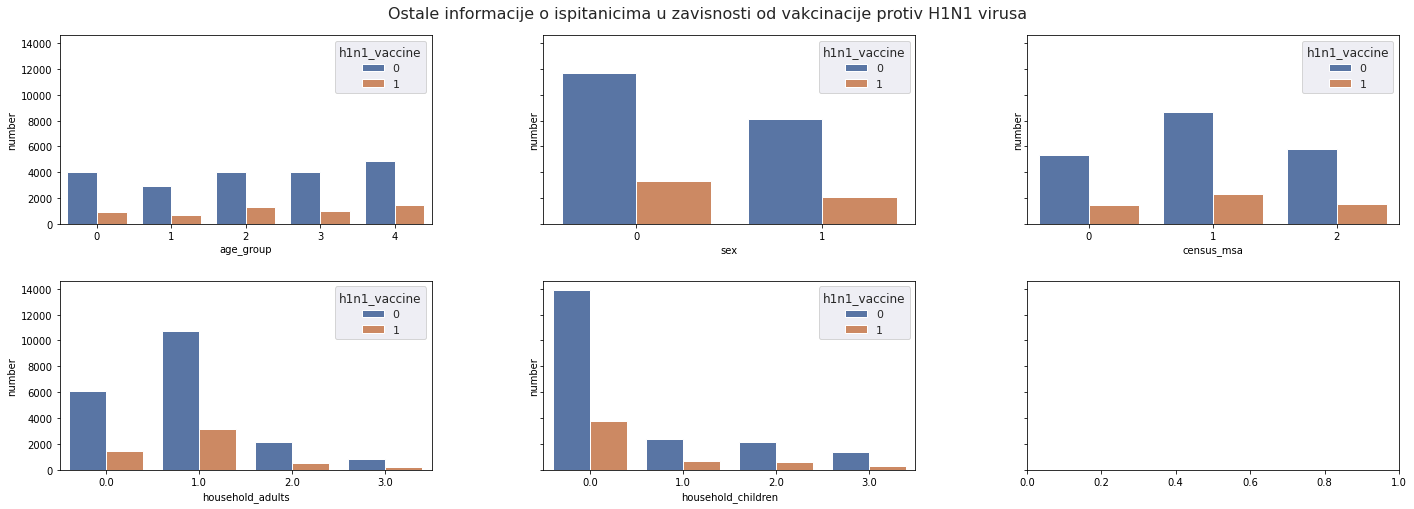

In [22]:
import math
col_num=3
fig_num=6
fig, axes = plt.subplots(math.ceil(fig_num/col_num), col_num, figsize=(24, 8), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

numlist=range(1,fig_num+1)
featurelist_ver=['age_group','sex','census_msa','household_adults','household_children']
sn.set(color_codes=True)
for i,feature in zip(numlist,featurelist_ver):
    x,y = feature, 'h1n1_vaccine'
    (transformed_data_df
    .groupby(x)[y]
    .value_counts()
    .rename('number')
    .reset_index()
    .pipe((sn.barplot,'data'), x=x,y='number',hue=y,ax=axes[math.ceil((i)/col_num)-1,(i-1)%col_num+1-1])
    )
            
fig.suptitle("Ostale informacije o ispitanicima u zavisnosti od vakcinacije protiv H1N1 virusa", fontsize=16,y=0.93)
fig.savefig("images/background_info_h1n1.png")
plt.show()

Teško je uočiti trend u podacima koji bi sugerisao na opredeljenje za ili protiv vakcine.

### Sezonski grip

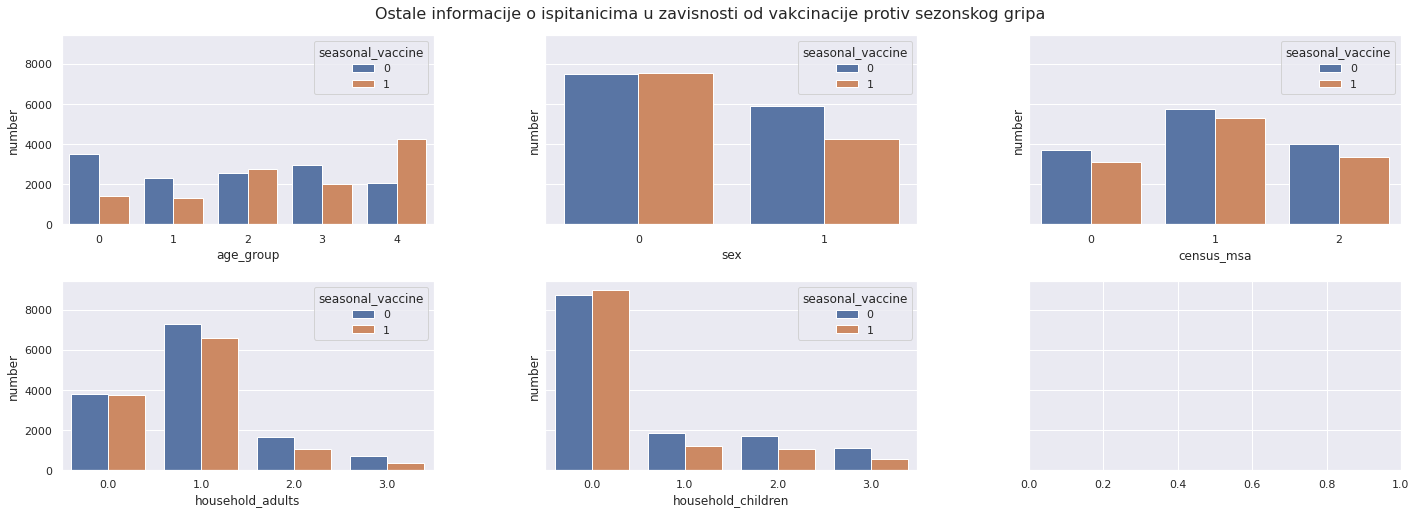

In [23]:
import math
col_num=3
fig_num=6
fig, axes = plt.subplots(math.ceil(fig_num/col_num), col_num, figsize=(24, 8), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

numlist=range(1,fig_num+1)
featurelist_ver=['age_group','sex','census_msa','household_adults','household_children']
sn.set(color_codes=True)
for i,feature in zip(numlist,featurelist_ver):
    x,y = feature, 'seasonal_vaccine'
    (transformed_data_df
    .groupby(x)[y]
    .value_counts()
    .rename('number')
    .reset_index()
    .pipe((sn.barplot,'data'), x=x,y='number',hue=y,ax=axes[math.ceil((i)/col_num)-1,(i-1)%col_num+1-1])
    )
            
fig.suptitle("Ostale informacije o ispitanicima u zavisnosti od vakcinacije protiv sezonskog gripa", fontsize=16,y=0.93)
fig.savefig("images/background_info_seas.png")
plt.show()

Ispitanici sa preko 65 godina se najčešće opredeljuju za vakcinu. Žene se nešto češće opredeljuju za vakcinu od muškaraca, a muškarci češće odbijaju vakcinu nego što se za nju opredeljuju. Ostali prediktori nisu naročito informativni.

## Uticaj prediktora na izlaz

### Sezonski grip

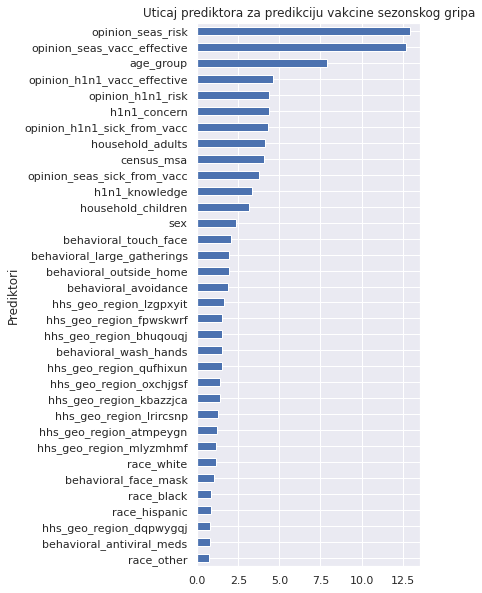

In [24]:
from sklearn.ensemble import RandomForestRegressor

data_df_ = transformed_data_df.drop(output_columns, axis=1)

rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(data_df_, transformed_data_df.seasonal_vaccine)

# prikaz uticaja pojedinačnih prediktora
rf_importance=pd.DataFrame({'Prediktori':np.array(data_df_.columns),'Uticaj': rf.feature_importances_*100 }).sort_values(by='Uticaj', ascending=False)

rf_importance.sort_values(by='Uticaj').plot(kind='barh',x='Prediktori', y='Uticaj',figsize=(4,10),legend=False,title="Uticaj prediktora za predikciju vakcine sezonskog gripa")
plt.savefig('images/feature_importance_seas.png')

### H1N1 virus

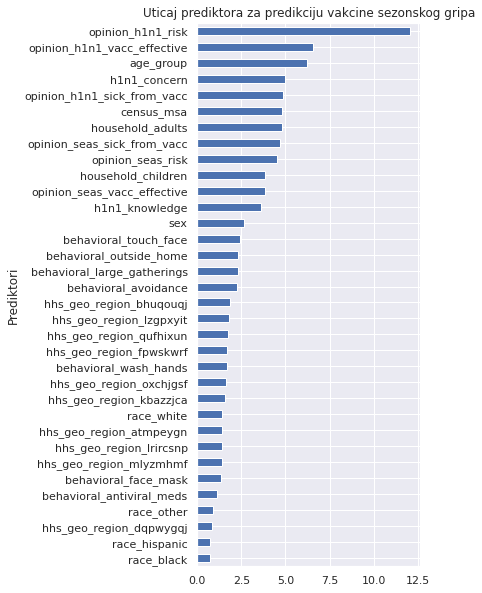

In [25]:
from sklearn.ensemble import RandomForestRegressor

data_df_ = transformed_data_df.drop(output_columns, axis=1)

rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(data_df_, transformed_data_df.h1n1_vaccine)

# prikaz uticaja pojedinačnih prediktora
rf_importance=pd.DataFrame({'Prediktori':np.array(data_df_.columns),'Uticaj': rf.feature_importances_*100 }).sort_values(by='Uticaj', ascending=False)

rf_importance.sort_values(by='Uticaj').plot(kind='barh',x='Prediktori', y='Uticaj',figsize=(4,10),legend=False,title="Uticaj prediktora za predikciju vakcine sezonskog gripa")
plt.savefig('images/feature_importance_h1n1.png')

Interesantna opservacija je da su tri najinformativnija prediktora za obe vrste vakcina isti, odnoseći se na klasu koju predviđamo. Očekivano, *one-hot* prediktori u ovakvim poređenjima retko mogu da dođu do izražaja u oni u oba slučaja zauzimaju poslednja mesta za uticaj.

### Izdvajanje konačnih prediktora

In [26]:
features = transformed_data_df.columns.tolist()
for label in output_columns:
    features.remove(label)
# features = list(filter(lambda x: 'hhs_geo_region' not in x, features))
print("Konačna lista predikotra:\n", features)

Konačna lista predikotra:
 ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'sex', 'census_msa', 'household_adults', 'household_children', 'hhs_geo_region_oxchjgsf', 'hhs_geo_region_bhuqouqj', 'hhs_geo_region_qufhixun', 'hhs_geo_region_lrircsnp', 'hhs_geo_region_atmpeygn', 'hhs_geo_region_lzgpxyit', 'hhs_geo_region_fpwskwrf', 'hhs_geo_region_mlyzmhmf', 'hhs_geo_region_dqpwygqj', 'hhs_geo_region_kbazzjca', 'race_white', 'race_black', 'race_other', 'race_hispanic']


# Izlazni podaci

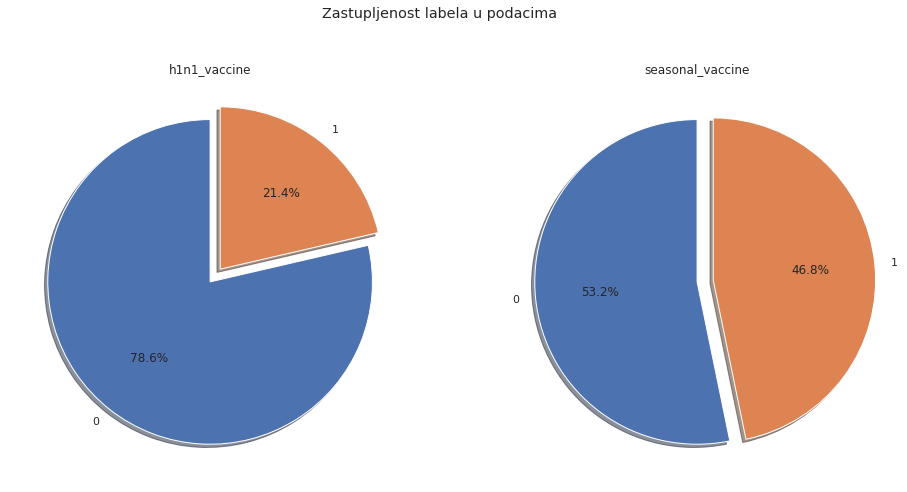

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax, label in zip(axes.ravel(),output_columns):
    counter = [len(transformed_data_df[transformed_data_df[label]==i]) for i in range(2)]
    ax.pie(counter, explode=(0, 0.1), labels=[0,1], autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax.set_title(label)
plt.suptitle("Zastupljenost labela u podacima")
plt.savefig('images/class_balance.png')
plt.show()

Jako je bitno primetiti nebalansiranost opredeljenja ispitanika za i protiv vakcinacije protiv H1N1 virusa za razliku od prilično balansiranog skupa podataka vezanih za sezonsku vakcinu. Ova informacija je od značaja pri obučavanju modela kao i pri njegovoj evaluaciji kako konačni estimator/klasifikator ne bi bio pomeren.

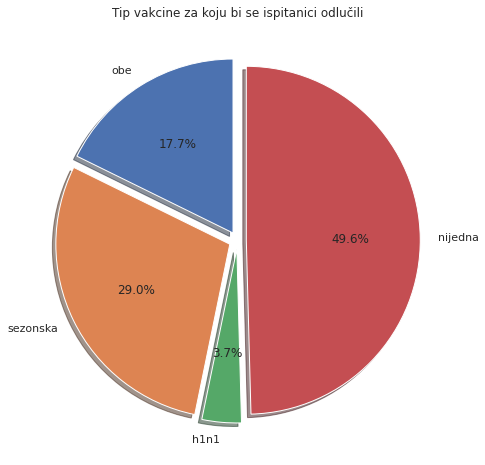

In [28]:
both = len(transformed_data_df[(transformed_data_df['seasonal_vaccine'] == 1) & (transformed_data_df['h1n1_vaccine'] == 1)])
seas = len(transformed_data_df[(transformed_data_df['seasonal_vaccine'] == 1) & (transformed_data_df['h1n1_vaccine'] == 0)])
h1n1 = len(transformed_data_df[(transformed_data_df['seasonal_vaccine'] == 0) & (transformed_data_df['h1n1_vaccine'] == 1)])
none = len(transformed_data_df[(transformed_data_df['seasonal_vaccine'] == 0) & (transformed_data_df['h1n1_vaccine'] == 0)])
counter = (both, seas, h1n1, none)

fig, ax = plt.subplots(ncols=1, figsize=(24,8))
ax.pie(counter, explode=(0.05, 0.05, 0.05, 0.05), labels=['obe', 'sezonska', 'h1n1', 'nijedna'], autopct='%1.1f%%',
    shadow=True, startangle=90)
ax.set_title("Tip vakcine za koju bi se ispitanici odlučili")
plt.savefig('images/vaccine_type.png')
plt.show()

Ukoliko uporedimo prethodni grafik koji ukazuje da ~53% ne želi da primi sezonsku vakcinu i trenutni gde ~50% ne želi da primi bilo kakvu vakcinu, možemo da zaključimo da je ljudi koji odbijaju da prime sezonsku vakcinu sa velikom verovatnoćom neće primiti ni vakcinu protiv virusa H1N1. Sa druge strane, ukoliko osoba ima interesovanja da se vakciniše protiv sezonskog gripa, nešto manje od polovine ispitanika pokazuje interesovanje da se vakciniše i vakcinom protiv H1N1 virusa. Jako je mali broj ljudi koji želi da primi isključivo vakcinu protiv virusa H1N1.

Pri selekciji modela će biti korišćena ugrađena metoda za podelu podataka u k strukova tako da je raspodela izlaznih vrednosti jednaka u svakom od njih. Mogućnost mešanja podataka je isključena zbog ponovljivosti eksperimenata i identičnih podela kod različitih modela. Identična metodologija je primenjena pri obučavanju, selekciji modela, evaluaciji i analizi grešaka za obe vrste labela.

# Predikcija vakcine sezonskog gripa

## Preprocesiranje podataka

In [29]:
RANDOM_STATE = 1234
TRAIN_SIZE = 0.9

X_train, X_test, y_train, y_test = train_test_split(transformed_data_df[features], transformed_data_df['seasonal_vaccine'],
                                                    train_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=transformed_data_df['seasonal_vaccine'])
                                                    
print("Obučavajući skup")
print(f"Dimenzije prediktora {X_train.shape}, dimenzije izlaza {y_train.shape}")
print(f"Tip promenljive prediktora {type(X_train)}, dimenzije izlaza {type(y_train)}")
print("Testirajući skup")
print(f"Dimenzije prediktora {X_test.shape}, dimenzije izlaza {y_test.shape}")
print(f"Tip promenljive prediktora {type(X_test)}, dimenzije izlaza {type(y_test)}")

# Skaliranje podataka
seasonal_scaler = StandardScaler()
# Računanje statistika na obučavajućem skupu
seasonal_scaler.fit(X_train)
# Primena standardizacije na obučavajućem i testirajućem skupu
X_train = seasonal_scaler.transform(X_train)
X_test = seasonal_scaler.transform(X_test)

Obučavajući skup
Dimenzije prediktora (22714, 34), dimenzije izlaza (22714,)
Tip promenljive prediktora <class 'pandas.core.frame.DataFrame'>, dimenzije izlaza <class 'pandas.core.series.Series'>
Testirajući skup
Dimenzije prediktora (2524, 34), dimenzije izlaza (2524,)
Tip promenljive prediktora <class 'pandas.core.frame.DataFrame'>, dimenzije izlaza <class 'pandas.core.series.Series'>


## Izbor modela modela

In [28]:
skfold = StratifiedKFold(n_splits=4, shuffle=False)

### Logistička regresija

In [29]:
from sklearn.linear_model import LogisticRegression

# Prostor hiper-parametara algoritma
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.5, 1, 5, 10, 20],
    'solver': ['liblinear'],
    'class_weight': ['balanced', None],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=LogisticRegression(),
                             param_grid=param_grid,
                             cv = skfold,
                             verbose=1)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/seasonal/LR_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 20 candidates, totalling 80 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,0.159641,0.006209,0.002988,0.000473,10,None,l1,1234,liblinear,"{'C': 10, 'class_weight': None, 'penalty': 'l1...",0.750836,0.748899,0.747622,0.744981,0.748085,0.002126,1
6,0.165431,0.020701,0.002619,0.000013,1,None,l1,1234,liblinear,"{'C': 1, 'class_weight': None, 'penalty': 'l1'...",0.750660,0.749076,0.747446,0.745157,0.748085,0.002037,1
10,0.170037,0.026435,0.003599,0.001014,5,None,l1,1234,liblinear,"{'C': 5, 'class_weight': None, 'penalty': 'l1'...",0.750836,0.748899,0.747622,0.744981,0.748085,0.002126,1
18,0.158354,0.005730,0.004133,0.001498,20,None,l1,1234,liblinear,"{'C': 20, 'class_weight': None, 'penalty': 'l1...",0.750836,0.748899,0.747622,0.744981,0.748085,0.002126,1
7,0.164702,0.009669,0.002623,0.000062,1,None,l2,1234,liblinear,"{'C': 1, 'class_weight': None, 'penalty': 'l2'...",0.751013,0.748899,0.747622,0.744628,0.748041,0.002312,5


Hiper-parametri najboljeg modela su:
{'C': 10, 'class_weight': None, 'penalty': 'l1', 'random_state': 1234, 'solver': 'liblinear'}


### Metoda nosećih vektora

In [31]:
from sklearn.svm import SVC

#### Linearni kernel

In [33]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['linear'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             cv = skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/seasonal/SVM_linear_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END C=1, kernel=linear, random_state=1234;, score=0.750 total time=  53.0s
[CV 2/4] END C=1, kernel=linear, random_state=1234;, score=0.746 total time=  47.0s
[CV 3/4] END C=1, kernel=linear, random_state=1234;, score=0.747 total time=  51.3s
[CV 4/4] END C=1, kernel=linear, random_state=1234;, score=0.743 total time=  50.2s
[CV 1/4] END C=5, kernel=linear, random_state=1234;, score=0.750 total time= 2.4min
[CV 2/4] END C=5, kernel=linear, random_state=1234;, score=0.747 total time= 2.4min
[CV 3/4] END C=5, kernel=linear, random_state=1234;, score=0.747 total time= 2.4min
[CV 4/4] END C=5, kernel=linear, random_state=1234;, score=0.743 total time= 2.3min
[CV 1/4] END C=10, kernel=linear, random_state=1234;, score=0.750 total time= 4.2min
[CV 2/4] END C=10, kernel=linear, random_state=1234;, score=0.746 total time= 4.2min
[CV 3/4] END C=10, kernel=linear, random_state=1234;, score=0.747 total time= 4.2min
[CV 4/4] END 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
1,139.401855,1.178251,2.368300,0.009373,5,linear,1234,"{'C': 5, 'kernel': 'linear', 'random_state': 1...",0.750132,0.746610,0.747446,0.743043,0.746808,0.002533,1
2,249.179420,1.192595,2.368013,0.020876,10,linear,1234,"{'C': 10, 'kernel': 'linear', 'random_state': ...",0.749956,0.746434,0.747270,0.743043,0.746676,0.002468,2
0,47.881262,2.151472,2.467718,0.176693,1,linear,1234,"{'C': 1, 'kernel': 'linear', 'random_state': 1...",0.749604,0.746434,0.747446,0.743043,0.746632,0.002367,3


Hiper-parametri najboljeg modela su:
{'C': 5, 'kernel': 'linear', 'random_state': 1234}


#### Polinomijalni kernel

In [34]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['poly'],
    'degree': [2, 3, 5],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             cv = skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/seasonal/SVM_poly_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END C=1, degree=2, kernel=poly, random_state=1234;, score=0.637 total time=  26.1s
[CV 2/4] END C=1, degree=2, kernel=poly, random_state=1234;, score=0.635 total time=  26.3s
[CV 3/4] END C=1, degree=2, kernel=poly, random_state=1234;, score=0.648 total time=  27.0s
[CV 4/4] END C=1, degree=2, kernel=poly, random_state=1234;, score=0.651 total time=  26.1s
[CV 1/4] END C=1, degree=3, kernel=poly, random_state=1234;, score=0.728 total time=  24.3s
[CV 2/4] END C=1, degree=3, kernel=poly, random_state=1234;, score=0.737 total time=  23.8s
[CV 3/4] END C=1, degree=3, kernel=poly, random_state=1234;, score=0.736 total time=  24.4s
[CV 4/4] END C=1, degree=3, kernel=poly, random_state=1234;, score=0.732 total time=  23.8s
[CV 1/4] END C=1, degree=5, kernel=poly, random_state=1234;, score=0.721 total time=  39.3s
[CV 2/4] END C=1, degree=5, kernel=poly, random_state=1234;, score=0.725 total time=  39.0s
[CV 3/4] END C=1, de

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
1,21.221947,0.260992,2.850842,0.008376,1,3,poly,1234,"{'C': 1, 'degree': 3, 'kernel': 'poly', 'rando...",0.727593,0.736749,0.736351,0.731948,0.733160,0.003726,1
2,35.814705,0.295491,3.608080,0.005296,1,5,poly,1234,"{'C': 1, 'degree': 5, 'kernel': 'poly', 'rando...",0.720725,0.724952,0.727369,0.729130,0.725544,0.003153,2
4,40.822264,2.294507,2.794737,0.423312,5,3,poly,1234,"{'C': 5, 'degree': 3, 'kernel': 'poly', 'rando...",0.711569,0.720902,0.716273,0.716626,0.716342,0.003304,3
5,66.990385,2.928885,3.356666,0.188878,5,5,poly,1234,"{'C': 5, 'degree': 5, 'kernel': 'poly', 'rando...",0.701356,0.709456,0.704650,0.718211,0.708418,0.006345,4
7,74.374479,1.728954,2.507825,0.068956,10,3,poly,1234,"{'C': 10, 'degree': 3, 'kernel': 'poly', 'rand...",0.702941,0.710160,0.702008,0.712046,0.706789,0.004378,5


Hiper-parametri najboljeg modela su:
{'C': 1, 'degree': 3, 'kernel': 'poly', 'random_state': 1234}


#### Gausovski kernel

In [35]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['rbf'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             cv=skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/seasonal/SVM_rbf_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END C=1, kernel=rbf, random_state=1234;, score=0.746 total time=  32.6s
[CV 2/4] END C=1, kernel=rbf, random_state=1234;, score=0.750 total time=  33.2s
[CV 3/4] END C=1, kernel=rbf, random_state=1234;, score=0.754 total time=  36.5s
[CV 4/4] END C=1, kernel=rbf, random_state=1234;, score=0.745 total time=  31.1s
[CV 1/4] END C=5, kernel=rbf, random_state=1234;, score=0.731 total time= 1.1min
[CV 2/4] END C=5, kernel=rbf, random_state=1234;, score=0.735 total time= 1.0min
[CV 3/4] END C=5, kernel=rbf, random_state=1234;, score=0.736 total time=  59.3s
[CV 4/4] END C=5, kernel=rbf, random_state=1234;, score=0.734 total time= 1.1min
[CV 1/4] END C=10, kernel=rbf, random_state=1234;, score=0.719 total time= 1.7min
[CV 2/4] END C=10, kernel=rbf, random_state=1234;, score=0.724 total time= 1.6min
[CV 3/4] END C=10, kernel=rbf, random_state=1234;, score=0.725 total time= 1.7min
[CV 4/4] END C=10, kernel=rbf, random_state=12

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,26.866152,2.002612,6.483192,0.222423,1,rbf,1234,"{'C': 1, 'kernel': 'rbf', 'random_state': 1234}",0.746082,0.749780,0.753610,0.745333,0.748701,0.003297,1
1,55.374316,2.112153,7.226833,0.461462,5,rbf,1234,"{'C': 5, 'kernel': 'rbf', 'random_state': 1234}",0.730939,0.735165,0.735646,0.734061,0.733953,0.001833,2
2,88.150688,6.415050,6.921714,0.244413,10,rbf,1234,"{'C': 10, 'kernel': 'rbf', 'random_state': 1234}",0.719317,0.723543,0.724903,0.726664,0.723607,0.002713,3


Hiper-parametri najboljeg modela su:
{'C': 1, 'kernel': 'rbf', 'random_state': 1234}


### Slučajna šuma

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Prostor hiper-parametara algoritma
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'max_features': ['sqrt','log2'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=param_grid,
                             cv = skfold,
                             verbose=3)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/seasonal/RF_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.738 total time=   0.5s
[CV 2/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.739 total time=   0.4s
[CV 3/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.735 total time=   0.4s
[CV 4/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.740 total time=   0.4s
[CV 1/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.740 total time=   0.8s
[CV 2/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.736 total time=   0.9s
[CV 3/4] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.730 total time=   0.8s
[CV 4/4] END criterion=gini, max

[CV 4/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=50, random_state=1234;, score=0.750 total time=   0.7s
[CV 1/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=1234;, score=0.758 total time=   1.4s
[CV 2/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=1234;, score=0.755 total time=   1.4s
[CV 3/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=1234;, score=0.759 total time=   1.5s
[CV 4/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=1234;, score=0.752 total time=   1.5s
[CV 1/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200, random_state=1234;, score=0.758 total time=   3.0s
[CV 2/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200, random_state=1234;, score=0.755 total time=   2.9s
[CV 3/4] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200, rand

[CV 2/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.755 total time=   2.2s
[CV 3/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.756 total time=   1.8s
[CV 4/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.751 total time=   2.2s
[CV 1/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.762 total time=   3.2s
[CV 2/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.755 total time=   3.1s
[CV 3/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.759 total time=   3.0s
[CV 4/4] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.753 total time=   3.0s
[CV 1/4] END criterion=entropy, max_depth=10, max_features=log

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
35,2.846829,0.048810,0.226739,0.011116,entropy,10,log2,200,1234,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.761578,0.755063,0.759246,0.753258,0.757286,0.003295,1
32,2.857275,0.050148,0.223644,0.003640,entropy,10,sqrt,200,1234,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.761578,0.755063,0.759246,0.753258,0.757286,0.003295,1
16,1.335374,0.007446,0.111601,0.001052,gini,10,log2,100,1234,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.758232,0.755239,0.758718,0.752025,0.756053,0.002680,3
13,1.339124,0.009789,0.111220,0.000641,gini,10,sqrt,100,1234,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.758232,0.755239,0.758718,0.752025,0.756053,0.002680,3
31,1.941548,0.176137,0.137250,0.019516,entropy,10,sqrt,100,1234,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.758232,0.754710,0.755724,0.751497,0.755041,0.002414,5


Hiper-parametri najboljeg modela su:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 1234}


## Obučavanje modela sa optimalnim hiper-parametrima i evaluacija

In [41]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Hiper-paramtri
lr_params = {'C': 10, 'class_weight': None, 'penalty': 'l1', 'random_state': 1234, 'solver': 'liblinear'}
svm_params = {'C': 1, 'kernel': 'rbf', 'random_state': 1234}
rf_params = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 1234}

# Instansciranje modela
lr = LogisticRegression(**lr_params)
svm = SVC(**svm_params)
rf = RandomForestClassifier(**rf_params)

# Obučavanje modela
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predikcija
y_hat_lr = lr.predict(X_test)
y_hat_svm = svm.predict(X_test)
y_hat_rf = rf.predict(X_test)

# Ispis rezultata
print("Logistička regresija")
print(classification_report(y_test, y_hat_lr))
print("Metoda nosećih vektora")
print(classification_report(y_test, y_hat_svm))
print("Random forest")
print(classification_report(y_test, y_hat_rf))

Logistička regresija
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1344
           1       0.73      0.71      0.72      1180

    accuracy                           0.74      2524
   macro avg       0.74      0.74      0.74      2524
weighted avg       0.74      0.74      0.74      2524

Metoda nosećih vektora
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1344
           1       0.74      0.71      0.72      1180

    accuracy                           0.75      2524
   macro avg       0.75      0.75      0.75      2524
weighted avg       0.75      0.75      0.75      2524

Random forest
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1344
           1       0.74      0.72      0.73      1180

    accuracy                           0.75      2524
   macro avg       0.75      0.75      0.75      2524
weighted avg    

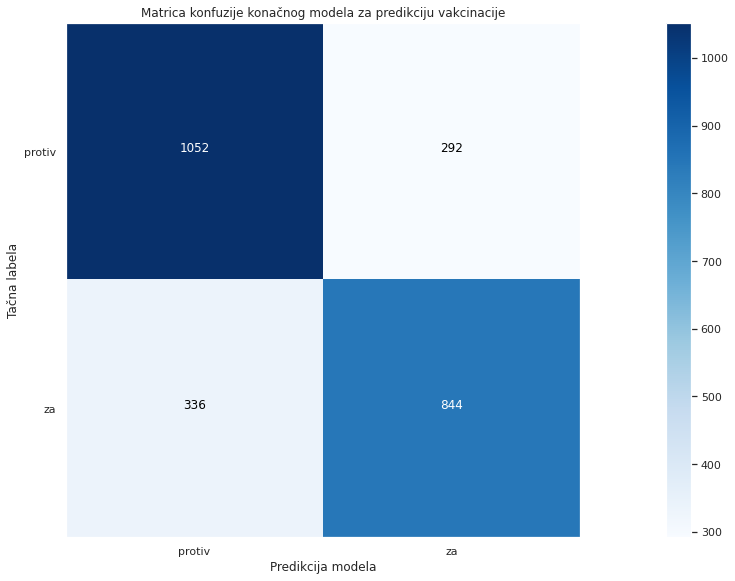

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat_rf)

figure = plt.figure(figsize=(24, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matrica konfuzije konačnog modela za predikciju vakcinacije")
plt.colorbar()
plt.xticks((0, 1), ["protiv", "za"], rotation=0)
plt.yticks((0, 1), ["protiv", "za"])

labels = np.around(cm)

threshold = cm.max() / 2.
for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)
plt.grid(False)
plt.tight_layout()
plt.ylabel("Tačna labela")
plt.xlabel("Predikcija modela")
plt.savefig('images/cm_seas.png')
plt.show()

#### Obučavajući skup

In [39]:
# Predikcija
y_hat_lr = lr.predict(X_train)
y_hat_svm = svm.predict(X_train)
y_hat_rf = rf.predict(X_train)

# Ispis rezultata
print("Logistička regresija")
print(classification_report(y_train, y_hat_lr))
print("Metoda nosećih vektora")
print(classification_report(y_train, y_hat_svm))
print("Random forest")
print(classification_report(y_train, y_hat_rf))

Logistička regresija
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     12090
           1       0.74      0.72      0.73     10624

    accuracy                           0.75     22714
   macro avg       0.75      0.75      0.75     22714
weighted avg       0.75      0.75      0.75     22714

Metoda nosećih vektora
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     12090
           1       0.80      0.76      0.78     10624

    accuracy                           0.80     22714
   macro avg       0.80      0.79      0.80     22714
weighted avg       0.80      0.80      0.80     22714

Random forest
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     12090
           1       0.80      0.76      0.78     10624

    accuracy                           0.80     22714
   macro avg       0.80      0.80      0.80     22714
weighted avg    

Pad od ~5% u tačnosti i F1-score-u pri evaluaciji obučavajućeg i testirajućeg skupa nam ukazuje da je model krenuo da uči obrasce koji se isključivo javljaju u obučavajućem skupu što nije dobro za konačne performanse modela. Konačni model ima tačnost od 73% i F1-score od 75%. Sa preciznošću od 74% možemo da tvrdimo da će se ispitanik opredeliti za vakcinaciju.  



Među svim ljudima za koje konačni model bude predvideo da će se vakcinisati, 74% će se vakcinisati. *(precision 1)*   
Među svim ljudima za koje konačni model bude predvideo da se neće vakcinisati, 76% se neće vakcinisati. *(precision 0)*  
Među svim ljudima koji će se vakcinisati, model će predvideti 72%. *(recall 1)*  
Među svim ljudima koji se neće vakcinisati, model će predvideti 78%. *(recall 0)*  

# Predikcija vakcine protiv H1N1 virusa

## Preprocesiranje podataka

In [43]:
RANDOM_STATE = 1234
TRAIN_SIZE = 0.9

X_train, X_test, y_train, y_test = train_test_split(transformed_data_df[features], transformed_data_df['h1n1_vaccine'],
                                                    train_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=transformed_data_df['h1n1_vaccine'])
                                                    
print("Obučavajući skup")
print(f"Dimenzije prediktora {X_train.shape}, dimenzije izlaza {y_train.shape}")
print(f"Tip promenljive prediktora {type(X_train)}, dimenzije izlaza {type(y_train)}")
print("Testirajući skup")
print(f"Dimenzije prediktora {X_test.shape}, dimenzije izlaza {y_test.shape}")
print(f"Tip promenljive prediktora {type(X_test)}, dimenzije izlaza {type(y_test)}")

# Skaliranje podataka
seasonal_scaler = StandardScaler()
# Računanje statistika na obučavajućem skupu
seasonal_scaler.fit(X_train)
# Primena standardizacije na obučavajućem i testirajućem skupu
X_train = seasonal_scaler.transform(X_train)
X_test = seasonal_scaler.transform(X_test)

Obučavajući skup
Dimenzije prediktora (22714, 34), dimenzije izlaza (22714,)
Tip promenljive prediktora <class 'pandas.core.frame.DataFrame'>, dimenzije izlaza <class 'pandas.core.series.Series'>
Testirajući skup
Dimenzije prediktora (2524, 34), dimenzije izlaza (2524,)
Tip promenljive prediktora <class 'pandas.core.frame.DataFrame'>, dimenzije izlaza <class 'pandas.core.series.Series'>


## Izbor modela modela

In [20]:
skfold = StratifiedKFold(n_splits=4, shuffle=False)

### Logistička regresija

In [32]:
from sklearn.linear_model import LogisticRegression

# Prostor hiper-parametara algoritma
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.5, 1, 5, 10, 20],
    'solver': ['liblinear'],
    'class_weight': ['balanced'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=LogisticRegression(),
                             param_grid=param_grid,
                             scoring='balanced_accuracy',
                             cv = skfold,
                             verbose=1)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/h1n1/LR_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 10 candidates, totalling 40 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
4,0.204977,0.108890,0.003273,0.000019,5,balanced,l1,1234,liblinear,"{'C': 5, 'class_weight': 'balanced', 'penalty'...",0.717051,0.705347,0.717942,0.707678,0.712005,0.005563,1
2,0.081345,0.029199,0.003258,0.000023,1,balanced,l1,1234,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.716939,0.705459,0.718018,0.707454,0.711967,0.005569,2
1,0.066132,0.001153,0.003681,0.000764,0.5,balanced,l2,1234,liblinear,"{'C': 0.5, 'class_weight': 'balanced', 'penalt...",0.716640,0.705347,0.717942,0.707678,0.711902,0.005471,3
3,0.066092,0.001145,0.003209,0.000003,1,balanced,l2,1234,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.716640,0.705347,0.717942,0.707678,0.711902,0.005471,3
5,0.066032,0.001137,0.003231,0.000032,5,balanced,l2,1234,liblinear,"{'C': 5, 'class_weight': 'balanced', 'penalty'...",0.716640,0.705347,0.717942,0.707678,0.711902,0.005471,3


Hiper-parametri najboljeg modela su:
{'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 1234, 'solver': 'liblinear'}


### Metoda nosećih vektora

In [22]:
from sklearn.svm import SVC

#### Linearni kernel

In [28]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['linear'],
    'class_weight': ['balanced'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             scoring='balanced_accuracy',
                             cv = skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/h1n1/SVM_linear_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END C=1, class_weight=balanced, kernel=linear, random_state=1234;, score=0.711 total time=  20.9s
[CV 2/4] END C=1, class_weight=balanced, kernel=linear, random_state=1234;, score=0.704 total time=  20.9s
[CV 3/4] END C=1, class_weight=balanced, kernel=linear, random_state=1234;, score=0.719 total time=  21.3s
[CV 4/4] END C=1, class_weight=balanced, kernel=linear, random_state=1234;, score=0.706 total time=  21.1s
[CV 1/4] END C=5, class_weight=balanced, kernel=linear, random_state=1234;, score=0.711 total time= 1.1min
[CV 2/4] END C=5, class_weight=balanced, kernel=linear, random_state=1234;, score=0.704 total time= 1.1min
[CV 3/4] END C=5, class_weight=balanced, kernel=linear, random_state=1234;, score=0.719 total time= 1.1min
[CV 4/4] END C=5, class_weight=balanced, kernel=linear, random_state=1234;, score=0.706 total time= 1.1min
[CV 1/4] END C=10, class_weight=balanced, kernel=linear, random_state=1234;, score=0

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,19.805759,0.163131,1.236442,0.005804,1,balanced,linear,1234,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.711312,0.704030,0.718629,0.706108,0.71002,0.005634,1
1,62.728366,0.288144,1.229042,0.002221,5,balanced,linear,1234,"{'C': 5, 'class_weight': 'balanced', 'kernel':...",0.711200,0.704141,0.718629,0.706108,0.71002,0.005599,1
2,112.001476,0.534970,1.242164,0.016115,10,balanced,linear,1234,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.711088,0.704253,0.718741,0.705996,0.71002,0.005627,1


Hiper-parametri najboljeg modela su:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 1234}


#### Polinomijalni kernel

In [29]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['poly'],
    'degree': [2, 3, 5],
    'class_weight': ['balanced'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             scoring='balanced_accuracy',
                             cv = skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/h1n1/SVM_poly_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END C=1, class_weight=balanced, degree=2, kernel=poly, random_state=1234;, score=0.631 total time=  11.7s
[CV 2/4] END C=1, class_weight=balanced, degree=2, kernel=poly, random_state=1234;, score=0.632 total time=  11.7s
[CV 3/4] END C=1, class_weight=balanced, degree=2, kernel=poly, random_state=1234;, score=0.638 total time=  12.0s
[CV 4/4] END C=1, class_weight=balanced, degree=2, kernel=poly, random_state=1234;, score=0.638 total time=  11.7s
[CV 1/4] END C=1, class_weight=balanced, degree=3, kernel=poly, random_state=1234;, score=0.685 total time=  10.4s
[CV 2/4] END C=1, class_weight=balanced, degree=3, kernel=poly, random_state=1234;, score=0.682 total time=  10.5s
[CV 3/4] END C=1, class_weight=balanced, degree=3, kernel=poly, random_state=1234;, score=0.688 total time=  10.7s
[CV 4/4] END C=1, class_weight=balanced, degree=3, kernel=poly, random_state=1234;, score=0.680 total time=  10.5s
[CV 1/4] END C=1, cl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_degree,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
1,9.208356,0.100579,1.342896,0.003876,1,balanced,3,poly,1234,"{'C': 1, 'class_weight': 'balanced', 'degree':...",0.684892,0.682353,0.687501,0.679762,0.683627,0.002880,1
2,12.322442,0.114035,1.530914,0.001644,1,balanced,5,poly,1234,"{'C': 1, 'class_weight': 'balanced', 'degree':...",0.663730,0.650934,0.675785,0.668332,0.664695,0.009035,2
4,13.436837,0.137253,1.184090,0.004470,5,balanced,3,poly,1234,"{'C': 5, 'class_weight': 'balanced', 'degree':...",0.658880,0.655344,0.668296,0.665409,0.661982,0.005130,3
7,21.069928,1.065411,1.119118,0.005227,10,balanced,3,poly,1234,"{'C': 10, 'class_weight': 'balanced', 'degree'...",0.650990,0.650366,0.666190,0.657660,0.656301,0.006385,4
5,17.879792,0.211062,1.342784,0.001831,5,balanced,5,poly,1234,"{'C': 5, 'class_weight': 'balanced', 'degree':...",0.646436,0.637158,0.648559,0.641936,0.643522,0.004384,5


Hiper-parametri najboljeg modela su:
{'C': 1, 'class_weight': 'balanced', 'degree': 3, 'kernel': 'poly', 'random_state': 1234}


#### Gausovski kernel

In [30]:
# Prostor hiper-parametara algoritma
param_grid = {
    'C': [1, 5, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=SVC(),
                             param_grid=param_grid,
                             scoring='balanced_accuracy',
                             cv=skfold,
                             verbose=4)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/h1n1/SVM_rbf_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END C=1, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.707 total time=  12.6s
[CV 2/4] END C=1, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.705 total time=  12.5s
[CV 3/4] END C=1, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.711 total time=  12.5s
[CV 4/4] END C=1, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.695 total time=  12.6s
[CV 1/4] END C=5, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.679 total time=  17.5s
[CV 2/4] END C=5, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.674 total time=  17.4s
[CV 3/4] END C=5, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.687 total time=  17.3s
[CV 4/4] END C=5, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.681 total time=  20.0s
[CV 1/4] END C=10, class_weight=balanced, kernel=rbf, random_state=1234;, score=0.669 total time=  22.3s
[CV

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,10.018097,0.041798,2.555522,0.022162,1,balanced,rbf,1234,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.706981,0.705273,0.711307,0.695377,0.704734,0.005833,1
1,15.595356,1.137646,2.444744,0.007754,5,balanced,rbf,1234,"{'C': 5, 'class_weight': 'balanced', 'kernel':...",0.678568,0.674097,0.687470,0.680511,0.680162,0.004818,2
2,20.769420,0.499276,2.351346,0.007405,10,balanced,rbf,1234,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.668784,0.658311,0.674042,0.671393,0.668133,0.005967,3


Hiper-parametri najboljeg modela su:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf', 'random_state': 1234}


### Slučajna šuma

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Prostor hiper-parametara algoritma
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'class_weight': ['balanced'],
    'max_features': ['sqrt','log2'],
    'random_state': [RANDOM_STATE]
}

# Kreiranje objekta pretrage u prostoru hiper-parametara
grid_searcher = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=param_grid,
                             scoring='balanced_accuracy',
                             cv = skfold,
                             verbose=3)

# Unakrsna validacija i račuanje metrika nad podacima za obučavanje
grid_searcher.fit(X_train, y_train)

# Izvlacenje DataFrame-a sa rezultatima
results_df = pd.DataFrame.from_dict(grid_searcher.cv_results_).sort_values('rank_test_score')
results_df.to_csv("results/h1n1/RF_results.csv")

# Prikaz rezultata
display(results_df.head())

# Parametri najboljeg rezultata
print("Hiper-parametri najboljeg modela su:")
print(results_df.head(1)['params'].values[0])

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.703 total time=   0.2s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.698 total time=   0.2s
[CV 3/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.703 total time=   0.2s
[CV 4/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, random_state=1234;, score=0.700 total time=   0.2s
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.704 total time=   0.4s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.699 total time=   0.4s
[CV 3/4] END class_weigh

[CV 3/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.714 total time=   0.8s
[CV 4/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=1234;, score=0.704 total time=   0.8s
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.710 total time=   1.6s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.700 total time=   1.6s
[CV 3/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.713 total time=   1.6s
[CV 4/4] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.702 total time=   1.6s
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=10, max_featur

[CV 4/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200, random_state=1234;, score=0.708 total time=   1.0s
[CV 1/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, random_state=1234;, score=0.714 total time=   0.3s
[CV 2/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, random_state=1234;, score=0.700 total time=   0.3s
[CV 3/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, random_state=1234;, score=0.710 total time=   0.3s
[CV 4/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, random_state=1234;, score=0.703 total time=   0.3s
[CV 1/4] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, random_state=1234;, score=0.710 total time=   0.5s
[CV 2/4] END class_weight=balanced, criterion=entropy, max_depth=5, 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
9,0.247345,0.000626,0.018495,0.000055,balanced,gini,5,log2,50,1234,"{'class_weight': 'balanced', 'criterion': 'gin...",0.716607,0.702203,0.713303,0.703437,0.708888,0.006194,1
6,0.247156,0.000433,0.018530,0.000040,balanced,gini,5,sqrt,50,1234,"{'class_weight': 'balanced', 'criterion': 'gin...",0.716607,0.702203,0.713303,0.703437,0.708888,0.006194,1
10,0.487467,0.000657,0.033759,0.000113,balanced,gini,5,log2,100,1234,"{'class_weight': 'balanced', 'criterion': 'gin...",0.712629,0.701904,0.713368,0.706385,0.708572,0.004709,3
7,0.488809,0.000498,0.033677,0.000078,balanced,gini,5,sqrt,100,1234,"{'class_weight': 'balanced', 'criterion': 'gin...",0.712629,0.701904,0.713368,0.706385,0.708572,0.004709,3
11,0.968996,0.002495,0.063972,0.000018,balanced,gini,5,log2,200,1234,"{'class_weight': 'balanced', 'criterion': 'gin...",0.709934,0.703475,0.713932,0.705674,0.708254,0.004017,5


Hiper-parametri najboljeg modela su:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50, 'random_state': 1234}


## Obučavanje modela sa optimalnim hiper-parametrima i evaluacija

In [47]:
from sklearn.metrics import classification_report

# Hiper-paramtri
lr_params = {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 1234, 'solver': 'liblinear'}
svm_params = {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 1234}
rf_params = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50, 'random_state': 1234}

# Instansciranje modela
lr = LogisticRegression(**lr_params)
svm = SVC(**svm_params)
rf = RandomForestClassifier(**rf_params)

# Obučavanje modela
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predikcija
y_hat_lr = lr.predict(X_test)
y_hat_svm = svm.predict(X_test)
y_hat_rf = rf.predict(X_test)

# Ispis rezultata
print("Logistička regresija")
print(classification_report(y_test, y_hat_lr))
print("Metoda nosećih vektora")
print(classification_report(y_test, y_hat_svm))
print("Random forest")
print(classification_report(y_test, y_hat_rf))

Logistička regresija
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1984
           1       0.38      0.69      0.49       540

    accuracy                           0.70      2524
   macro avg       0.64      0.69      0.64      2524
weighted avg       0.78      0.70      0.72      2524

Metoda nosećih vektora
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1984
           1       0.40      0.66      0.50       540

    accuracy                           0.71      2524
   macro avg       0.64      0.69      0.65      2524
weighted avg       0.78      0.71      0.73      2524

Random forest
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1984
           1       0.39      0.70      0.50       540

    accuracy                           0.70      2524
   macro avg       0.64      0.70      0.64      2524
weighted avg    

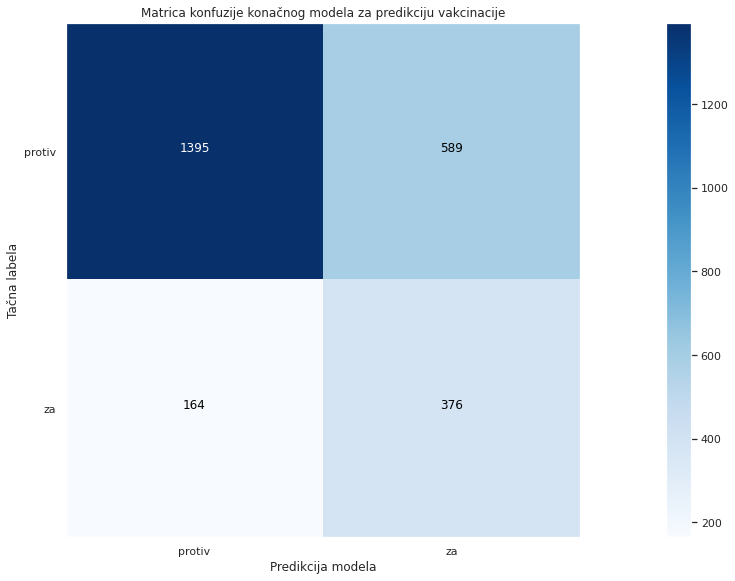

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat_rf)

figure = plt.figure(figsize=(24, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matrica konfuzije konačnog modela za predikciju vakcinacije")
plt.colorbar()
plt.xticks((0, 1), ["protiv", "za"], rotation=0)
plt.yticks((0, 1), ["protiv", "za"])

labels = np.around(cm)

threshold = cm.max() / 2.
for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

plt.grid(False)
plt.tight_layout()
plt.ylabel("Tačna labela")
plt.xlabel("Predikcija modela")
plt.savefig('images/cm_h1n1.png')
plt.show()

#### Obučavajući skup

In [46]:
# Predikcija
y_hat_lr = lr.predict(X_train)
y_hat_svm = svm.predict(X_train)
y_hat_rf = rf.predict(X_train)

# Ispis rezultata
print("Logistička regresija")
print(classification_report(y_train, y_hat_lr))
print("Metoda nosećih vektora")
print(classification_report(y_train, y_hat_svm))
print("Random forest")
print(classification_report(y_train, y_hat_rf))

Logistička regresija
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     17858
           1       0.41      0.70      0.52      4856

    accuracy                           0.72     22714
   macro avg       0.65      0.71      0.66     22714
weighted avg       0.79      0.72      0.74     22714

Metoda nosećih vektora
              precision    recall  f1-score   support

           0       0.89      0.75      0.82     17858
           1       0.42      0.67      0.52      4856

    accuracy                           0.73     22714
   macro avg       0.66      0.71      0.67     22714
weighted avg       0.79      0.73      0.75     22714

Random forest
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     17858
           1       0.41      0.71      0.52      4856

    accuracy                           0.72     22714
   macro avg       0.65      0.71      0.66     22714
weighted avg    

Kod predikcije opredeljenja ispitanika da se vakcinišu vakcinom protiv virusa H1N1 ne postoji indikator da je došlo do preobučavja ali možemo doći do zaključka da model nema mogućnost da u potpunosti nauči kada će se ispitanik odlučiti za vakcinu na osnovu dostupnih podataka. Konačni model ima tačnost od 70% i F1-score od 73%. Sa preciznošću od 39% možemo da tvrdimo da će se ispitanik opredeliti za vakcinaciju. Nebalansiranost klasa ipak dolazi do izražaja i konačni estimator je pomeren.  

Među svim ljudima za koje konačni model bude predvideo da će se vakcinisati, 39% će se vakcinisati. *(precision 1)*   
Među svim ljudima za koje konačni model bude predvideo da se neće vakcinisati, 89% se neće vakcinisati. *(precision 0)*  
Među svim ljudima koji će se vakcinisati, model će predvideti 70%. *(recall 1)*  
Među svim ljudima koji se neće vakcinisati, model će predvideti 70%. *(recall 0)*  

# Zaključak

U trenutku istraživanja, ljudsko društvo se nalazi u značajno većoj pandemiji virusa COVID-19. Analizuran je skup od ~27000 ispitanika. Trenutno je približno 64% Američkih državljanina dvostruko (potpuno) vakcinisano protiv virusa COVID-19 od ukupno 329000000. Kako očekivali bi nešto bolje performanse od modela, neophodno je prikupiti dosta više podataka koji se definitivno mogu pribaviti u jeku pandemije. Model ima smisla primeniti u targetiranju društvenih grupa koje imaju volju da se vakcinišu i na taj način uticati na trend vakcinacije.


Tema budućih istraživanja mogla bi da bude i istovremena predikcija više labela ili korišćenje trenutnih labela kao prediktore za predikciju vakcinacije protiv COVID-19 virusa.